In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip as gz

In [3]:
# Defines the data files we will be working with!
mac = '../data/ALL.chr22.phase3.genotypes.mac.gz'
total = '../data/ALL.chr22.phase3.genotypes.total.gz'
clst_labels = '../data/ALL.chr22.phase3.clst.gz'


'''
  Generate a set of data types to reduce memory overhead
'''
def data_type_dict(freq_file):
    type_dict = {}
    with gz.open(freq_file, 'rt') as f:
        header = f.readline()
        categories = header.split()
        for i in categories:
            if (i == 'A1') | (i == 'A2'):
                type_dict[i] = 'category'
            elif (i == 'CHR'):
                type_dict[i] = 'uint8'
            elif (i == 'SNP'):
                type_dict[i] = 'uint64'
            else:
                type_dict[i] = 'uint32'
    return(type_dict)


'''
  Reads in frequency file and cluster labels and join them for the output
 
  Input:
    - mac_file: file detailing multi-dimensional allele counts
    - total_file: file detailing total number of chromosomes genotyped 
    - clst_labels : data file with [CHR, SNP, A1, A2, CLST] columns
  Returns:
    - merged_label_df : merged data table with all columns present
    - pop_names : population labels that can be used in plotting later
'''
def read_freq_files(mac_file, total_file, clst_labels):
    type_dict_mac = data_type_dict(mac_file)
    type_dict_total = data_type_dict(total_file)
    type_dict_clst = data_type_dict(clst_labels)
    if 'DIST' in type_dict_clst:
        del type_dict_clst['DIST']
    mac_file_df = pd.read_table(mac_file, dtype=type_dict_mac, low_memory=True)
    total_file_df = pd.read_table(total_file, dtype=type_dict_total, low_memory=True)
    clst_labels_df = pd.read_table(clst_labels, dtype=type_dict_clst, low_memory=True)
    merged_label_df = mac_file_df.merge(clst_labels_df, on=['CHR', 'SNP', 'A1', 'A2'])
    total_file_merged_df = total_file_df.merge(clst_labels_df, on=['CHR','SNP','A1','A2'])
    df_colnames = merged_label_df.columns
    pop_names = df_colnames[np.isin(df_colnames, ['CHR', 'SNP', 'A1', 'A2', 'CLST', 'Label','DIST'], invert=True)]
    return(merged_label_df, total_file_merged_df, pop_names)


In [7]:
%%time
merged_mac_df, merged_total_df, pop_names = read_freq_files(mac, total, clst_labels)

CPU times: user 11.4 s, sys: 1.72 s, total: 13.1 s
Wall time: 13.8 s


In [12]:
# Filtering to a random subset of the SNPs from the original data
#1. Subsample
thinning = 10000
idx_rand = np.random.randint(0,merged_mac_df.shape[0],thinning)

# Subsetting the minor allele count and the total
mac_idx = np.array(merged_mac_df[pop_names], dtype=np.uint32)[idx_rand,:]
total_idx = np.array(merged_total_df[pop_names], dtype=np.uint32)[idx_rand,:]
subsample_X = mac_idx / total_idx

# Setting nans to be 0
np.nan_to_num(subsample_X, copy=False)
subsample_clst_labels = np.array(merged_mac_df['CLST'])[idx_rand]

In [13]:


'''
  Categorizes clusters based on their labels
  
  Input:
    - X : multidimensional SFS (snp x pops)
    - labels : numpy array of cluster labels (per snp)
  Returns:
    - clst_data_dict: dictionary of data 
    - k : list of labels
'''
def cluster_specific_split(X,labels):
    if X.shape[0] != len(labels):
        raise ValueError('rows of X does not equal the number of labels!')
    k = np.unique(labels)
    clst_data_dict = {}
    for i in k:
        subs_data = X[(labels == i), :]
        clst_data_dict[i] = subs_data
    return(clst_data_dict, k)


'''
  Transform MAF to log10 scale
      - all of the 0 entries are replaced with 0 again 
'''
def rescale_log(X, eps):
    A = np.log10(X + eps)
    return(A)

 
'''
  Creates output data for plotting clustering of allele frequencies
  
  Input:
    - X : multidimensional SFS
    - labels : clustering labels
    - spc : pixel spacing between cluster rows
    - eps : value given to masked rows
    - mean : boolean to take the mean of each row
    - sort_af : sort clusters by minor allele frequency
  Output:
    - aggregated : restructured numpy matrix to plot
    - tick_idx : places for tick marks in clustermap
    - tick_label : cluster labelings for each tick
'''
def extract_clustering_means(X, labels, spc=5, eps=1e-8, mean=False, sort_af=True):
    sorted_list, k = cluster_specific_split(X,labels)
    n_clust = len(k)
    if sort_af:
        mean_maf = [np.mean(sorted_list[i]) for i in k]
        k2 = np.argsort(mean_maf)[::-1]
    else:
        k2 = k
    aggregated = np.zeros(((X.shape[0]+spc*n_clust),X.shape[1]))
    row_count = 0
    tick_idx = []
    tick_label = []
    for i in range(n_clust):
        cur_x = sorted_list[k2[i]]
        tick_label.append(str(i))
        if mean:
            cur_x_mean = np.mean(cur_x , axis=0)
            for x in range(cur_x.shape[0]):
                cur_x[x,:] = cur_x_mean
        n_row = cur_x.shape[0]
        tick_idx.append(row_count+int((n_row/2)))
        aggregated[row_count:(row_count+n_row),:] = cur_x
        row_count += n_row
        a = np.empty((spc,X.shape[1]))
        a[:] = eps
        aggregated[row_count:row_count+spc,:] = a
        row_count += spc
    return(aggregated, tick_idx, tick_label)

In [14]:
# Setting spacing in the plots and the fudge factor for the log-scaling 
spc=100
eps=1e-6
mean=False
%time clstr_plots, tick_id, tick_labels = extract_clustering_means(subsample_X, subsample_clst_labels, spc=spc, eps=eps, mean=mean, sort_af=True)

CPU times: user 10.6 ms, sys: 7.49 ms, total: 18.1 ms
Wall time: 16.5 ms


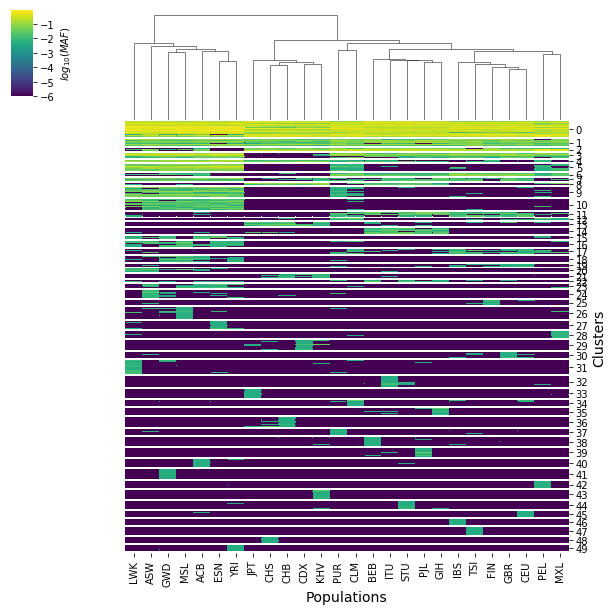

In [15]:
masked = (clstr_plots == eps)

#3. Heatmap
logscale=True
A = rescale_log(clstr_plots, eps=eps) if logscale else clstr_plots
label = r'$log_{10}(MAF)$' if logscale else r'MAF' 

g = sns.clustermap(A, row_cluster=False, yticklabels=[], xticklabels=pop_names, cmap='viridis', mask=masked, cbar_kws={"label":label})
g.ax_heatmap.set_yticks(tick_id);
g.ax_heatmap.set_yticklabels(tick_labels);
g.ax_heatmap.set_xlabel(r'Populations', fontsize=14);
g.ax_heatmap.set_ylabel(r'Clusters', fontsize=14);